![twitch](Images/twitchlogo.jpg)

# Twitch Hate Chat Identification
---
Author: [Kelsey Lane](kelsklane@gmail.com)

## Overview
---
This project aims to better identify hate chats on Twitch livestreams. A subset of data consisting of four streamers and nine total streams from [this Harvard database](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VE0IVQ) is used in this project. These streams occurred during April - June of 2018. Sentiment analysis is used to identify negative comments which can be used to flag hate chats as they are sent. The relative importance of different words that predict hate chats can also be pulled from the model to help build a better filter. The packages used for this project can be seen in the environment file provided in the repository.

## Technical Overview
---
The data I'm using for this project are chat messages scraped from Twitch livestreams with metadata about the time the message was sent, how far into the stream the message was sent and more. This is suited for the business problem as the aim is to help Twitch more efficiently screen and filter out hate messages, so modeling the sentiment of the messages is a step towards this. To prep the data I used VADER from NLTK to assign a negative or not negative label to each chat. As for cleaning the data I filtered out as many messages sent by bots as I could and got rid of any messages with links using regular expressions, as these are often just advertisements and not real chats. For the tokenization process, I used NLTK's Tweet tokenizer as chats are similar in structure to tweets. I left capitalization and stop words in, as short, casual messages can perform better when retaining this information. Finally, unnecessary punctuation is filtered out and the remaining words are lemmatized to help reduce the number of features. The main two models used for the sentiment analysis are the Multinomial Bayes and Logistic Regression models from sklearn, as these often work well with sentiment analysis and are simple enough to run effectively with the amount of data I have. Sklearn's CountVectorizer was used alongside a custom tokenization function to break the chats up and these vectorizers were tuned using a GridSearch to alter the maximum number of features in the dataset, the frequency cutoff for the higher frequency words, whether bigrams should be used or not, and if the words should all be lowercase or not. The logistic regression model was also tuned, but the only change from the default was to increase the number of iterations. While iterating throughout the models, a train test split was performed and the training data was further cross validated using sklearn's `cross_validate` library. The final model is a logistic regression that has an accuracy of 95% with a recall of 76%.

## Business Understanding
---
Twitch has an issue with cyberbullying in their chats. According to a [survey done in 2018](https://blog.streamelements.com/streamelements-analysis-on-twitch-bullying-c3f2b2240318), over a quarter of people using Twitch have seen some type of bullying in chat messages. In addition, over 13% of streamers have felt bullied at some point. While Twitch has measures in place for combating bullying, only 26.4% of people thought they were effective. This bullying can have serious consequences for the mental health of not only the streamers, but also the viewers participating in the chat. Therefore, in an effort to help Twitch's safety operations team better tackle this issue and create a safer platform, I propose using a sentiment analysis model to help better identify hate chats. This model can help flag these chats faster for moderators to view and deal with. Words common to hate messages can also be identified and added to existing filters to strengthen them. This can help combat the bullying issue present on Twitch's platform while also creating a more welcoming environment, especially for BIPOC and LGBTQ+ people that are often the target of this bullying.

## Data Understanding
---
The dataset for this project comes from a [Harvard study](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VE0IVQ) and contains chat logs from 50 different streamers with around 25 streams per streamer. As the total original data contains too many rows to efficiently run on my computer, I paired the dataset down to four streamers with nine streams total. This means there are two streams per streamer. However, KingRichard has three streams to keep the number of chats at about 25,000 for each person. In the end, this resulted in a dataset with 102,700 rows where each row is a unique chat. When creating the dataset read in below, only chats with the user commenter type were kept, as chats from admins and moderators are not going to contain hate messages. The `fragments` column from the original dataset was broken out into a `twitch_chat` column and `emotes` column to better manipulate the data. The original dataset also contained chats that were edited, though it was never made clear if this was by users or moderators editing the chat for content. Due to this uncertainty and the fact there weren't that many edited chats, any edited rows are dropped. Finally, any chats that start with an exclamation point are filtered out, as on Twitch these are commands used to call bots and are not actual comments. The final dataset was created by merging the nine streams together and dropping the `fragments` and `updated_at` columns, as these supply no additional information. This smaller dataset is imported in the cell below and the code for generating it can be found in the Merge_datasets notebook in the notebook folder.

In [1]:
#Imports libraries for labeling data
from textblob import TextBlob
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Imports libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Imports libraries for text cleaning and manipulation
import nltk
import re
import collections
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

#Imports libraries for modeling and evaluation
from sklearn.model_selection import train_test_split, cross_validate
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score, accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 

#Imports dataset
df = pd.read_csv('data/small_merged_chats')

Unfortunately, in the process of saving the modified dataframe and opening it again eight of the chats get corrupted and become NaNs, so these rows are dropped.

In [2]:
#Gets rid of rows that got turned to NaNs
df = df.dropna(subset = ['body'])

While doing data exploration, I found some bot messages sending links to the streamers Patreon or Discord server, as well as advertisements for other Twitch streams. In an effort to narrow the data down to only human messages, any chat message with a link is dropped from the dataset. While this may drop some non-bot related messages, it seemed to be the cleanest way to identify these false rows.

In [3]:
#Get rid of chats with links (often promo/not real messages)
def ad(chat):
    result = False
    #Change result to True if link present in chat
    result = bool(re.search(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)', chat))
    result = bool(re.search(r'http\S+', chat))
    return result

#Makes ad column and gets rid of any ad messages
df['is_ad'] = df['body'].apply(ad)
df = df[df['is_ad'] == False]

Finally, in preparation for generating the labels for the data, certain emotes are truncated down to one form. Some emotes have different variants that are simply cosmetic, but the way they get rendered in text is as different "words." To reduce the number of extra words that get counted, the most popular emotes with a lot of variations are replaced with their basic form.

In [4]:
#Changes popular emojis to one type so no variants ie) pog + pogChamp -> pog + pog
def emoji_shorten(chat):
    chat = re.sub(r'(?i) \bpog(\w)*\b |\bpog(\w)*\b', 'pog', chat)
    chat = re.sub(r'(?i) \blul(\w)*\b |\blul(\w)*\b', 'lul', chat)
    chat = re.sub(r'(?i) \bkappa(\w)*\b |\bkappa(\w)*\b', 'kappa', chat)
    return chat

#Creates new column with emojis shortened to simple form
df['chats'] = df.body.apply(lambda x: emoji_shorten(x))

VADER is used to create the target labels for the data. As Twitch has a lot of platform specific words, some of the more popular ones are added to VADER's lexicon to generate more accurate labels. The full added vocabulary is included below, where the sentiment values are calculated from [this study](https://dl.acm.org/doi/10.1145/3365523) that had people rate the positive, negative, or neutral sentiment of various Twitch emotes and slang. Some variations of words that are intentional misspellings of existing ones are also included below and marked with the same sentiment value as the original word, ie) nice vs. noice.

In [5]:
#Words to add to VADER
new_words = {
    'noice': 1.8,
    'scum': -2.0,
    'kap': 0.5,
    'kappa': 0.5,
    'lul': 1.8,
    'omegalol': 1.8,
    'strats': 2.0,
    'rekt': 0,
    'owo': 1.0,
    'tweaker': -2.3,
    'pog': 2.8,
    'pag': 2.8,
    'incel': -3.1,
    'tilted': -0.7,
    'feelsbadman': -2.6,
    'feelsgoodman': 3.7,
    'trash': -2.0,
    'rip': -1.2,
    'ez': 1.9,
    'clap': 2.7,
    'hyperbruh': -0.6,
    'f': 0.5,
    'F': 0.5,
    #Discord changed to 0 as it refers to a messaging platform
    'discord': 0,
    'PJSalt': -1.2,
    'Kreygasm': 2.8,
    'kreygasm': 2.8,
    'homo': -3.5,
    'clip': 0.5,
    'rAcIsM': -3.1,
    'based': 2.0,
    'Based': 2.0,
    'PepeHands': -1.7,
    'WutFace': -1.7,
    'FailFish': -2.0,
    'BabyRage': -1.6,
    'ANELE': -0.8,
    'haHAA': -0.5,
    'ResidentSleeper': -1.2,
    'cmonBruh': -1.0,
    #Change sentiment to neutral as looking for hate specifically
    ':(': 0
}

Finally, the labels are generated using VADER below. Each chat is sorted into either a positive, neutral, or negative sentiment list. A one is assigned to any chat in the negative list, while a 0 is assigned to any positive or neutral chat in the dataframe to create the target. Since I am only looking for chats with hate, the positive and neutral chats are lumped together. The normalized count of these labels is printed as well, and there is a class imbalance present in the data that will need to be addressed.

In [6]:
#Creates labels for data
# WARNING: Takes a while to run
polarity = 0
neutral_list = []
negative_list = []
positive_list = []
for chat in df.chats:
    #Sets up chat for analysis and initializes VADER object
    analysis = TextBlob(chat)
    vad = SentimentIntensityAnalyzer()
    #New words get added to vocabulary
    vad.lexicon.update(new_words)
    score = vad.polarity_scores(chat)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity
    #Assigns chat to either positive, negative, or neutral
    if neg > pos:
        negative_list.append(chat)
    elif pos > neg:
        positive_list.append(chat) 
    elif pos == neg:
        neutral_list.append(chat)

#Labels the data based on VADER results
df["label"] = np.where(df["chats"].isin(negative_list), 1, 0)
df.label.value_counts(normalize = True)

0    0.89037
1    0.10963
Name: label, dtype: float64

Unfortunately, there are a lot of limitations present with the data. For one, the VADER labeling assigns chats as negative or not negative, but these negative chats aren't all hate. However, there is no neat way to filter out specifically the hate messages from ones that aren’t. While expanding VADER's lexicon can help with identification, models built with these labels will pick up on other negative chats in addition to hate chats. Another limitation is that words can be intentionally misspelled to bypass the filters on Twitch. However, due to the wide variation in misspellings and potential overlap with other words, I didn't attempt to spell check chats to target these words. As a result, there may also be hate messages that slip by. Another limitation is the potential presence of other bot chats aside from the advertisements filtered out earlier. As different streamers can set up custom bots that say different things in response to user prompts, it's not easy to find and filter for all these messages. The streamers included in this dataset are also all well known. As a result, they have more moderators and may actually regulate their chats better when compared to smaller or mid-sized streamers. Therefore, scraping and looking at Twitch chats for smaller streamers would make for more robust data. Finally, the lack of diversity in streamers in the dataset I pulled from originally means that these hate messages may not fully encompass what’s on the platform. As a result, hate directed towards certain minority groups may be underrepresented in the data and not picked up by the models.

## Data Preparation
---
In an effort to help better identify hate chats, additional features were added to the data. The first is the time of day of the stream, as streams at night may receive more or less hate than those during the day. Due to the overwhelming amount of streams occurring at night, the stream are split into three groups. A stream is marked as being in the day if it falls between 7am to 8pm. After that, night is broken into night, consisting of 8pm to midnight, and late night, which is midnight to 7am.

In [7]:
#Finds the hour of stream at time of comment
df['created_at'] = pd.to_datetime(df['created_at'])
df['hour'] = df.created_at.apply(lambda x: x.hour)

#Sorts chat into day/night/late night based on hour chat was made
def day_night(hour):
    if (hour >= 7) and (hour < 20):
        return 'Day'
    elif (hour >= 20) and (hour <= 23):
        return 'Night'
    else:
        return 'Late Night'
    
#Creates the column
df['day_night'] = df.hour.apply(day_night)

Other features added were if the original chat included an emote, as some emotes require the user to subscribe to the Twitch streamer. Therefore, these users are less likely to comment hate messages and this information could help improve the model. The ratio of capital letters in the chat is also included as its’ own feature to help capture the energy of the sentiment. As some models make all the chats lowercase, this information can get lost so it is preserved and amplified here.

In [8]:
#Did the user include an emote
def any_emojis(emotes):
    if emotes[2] == 'N':
        return 0
    else:
        return 1
    
#Adds if chat contains emojis or not
df['any_emojis'] = df.emotes.apply(any_emojis)
    
    
#Ratio capital to length tweet
def capital_letter_ratio(chat):
    if type(chat) == float:
        return 0
    if len(chat) == 0:
        return 0
    capital_count = 0
    for c in chat:
        if c.isupper():
            capital_count += 1
    return capital_count / len(chat)

#Adds ratio of capital letters
df['cap_ratio'] = df.twitch_chat.apply(capital_letter_ratio)

Another feature added is `offset_percent`. In the original dataset, offset represents how many seconds from the start of the stream the chat was made. To make this consistent, the offset was divided by the length of the stream to get the percent value for how far into the stream the comment was made. This is a useful feature to add as certain events in the stream may have triggered people to leave hate chats, and thus the timing the chat was sent may give us useful information.

In [9]:
#Grabs the max offset value as the length of stream and the stream associated with it
graph = df.groupby(['video_id'])['offset'].max()
videos = list(graph.index)
max_time = list(graph.values)

#Creates list of sets of the max time for each stream
time_pairings = []
for i, v in enumerate(videos):
    time_pairings.append((videos[i], max_time[i]))

#Finds the length of the stream for each chat
def find_time(video):
    for pair in time_pairings:
        if video == pair[0]:
            return pair[1]

#Creates the length of stream and uses that to make the offset percent
df['max_time'] = df.video_id.apply(find_time)
df['offset_percent'] = (df.offset / df.max_time) * 100

The last feature added is the total comments made by each user during a stream. While it's not clear if these anonymized ids are kept between streams, they are treated as unique to each stream. This can be a useful feature as sometimes people may spam hate comments, so the quantity of chats made by a user may help distinguish hate chats from regular ones.

In [10]:
#Counts the number of comments made by each user
counter = collections.Counter(df.commenter_id)

#Adds the number of comments made by the user
def commenter_count(id):
    return counter[id]
df['total_comments'] = df.commenter_id.apply(commenter_count)

This leaves the dataset with a lot of features. Many are leftover columns used to create other ones, so the dataset is paired down to the relevant columns. The `body` and `twitch_chat` columns are dropped as they have the same information as the processed `chat` column. `channel_id` and `commenter_id` are dropped as they provide redundant information with other columns in the dataset. For similar reasons, `is_ad`, `created_at`, `offset`, `hour`, `emotes`, and `max_time` are dropped as they were used as intermediaries to create other columns or to drop irrelevant rows and aren't necessarily useful on their own.

In [11]:
#Drops irrelevant columns
df = df.drop(columns = ['body', 'channel_id', 'commenter_id', 'is_ad', 'created_at', 
                  'offset', 'hour', 'max_time', 'twitch_chat', 'emotes'], axis = 1)

This leaves the final dataset with eight columns. `label` is the target column while `chats` now contains the processed chat message to be analyzed. The remaining six columns are extra features that can help enhance the performance of the model. `day_night`, `any_emojis`, `cap_ratio`, `offset_percent`, and `total_comments` are kept as engineered features. Finally, `video_id` is kept as a variable, since different streams can attract different amounts of hate. As this is a categorical column, it is converted to a string below.

In [12]:
#Changes id to string
df['video_id'] = df['video_id'].astype(str)

Finally, the function used to tokenize the chats in the vectorizers is included below. Any non-English characters are stripped from any chats as the emotes are represented as words, so there is no worry of getting rid of emoji-related information by doing this. The chats are then tokenized using NLTK's Tweet Tokenizer to help capture the nuances of causal language present on Twitch. Finally, any punctuation that is not likely to indicate emotion are stripped from the tokens and the resulting words are lemmatized, as word variations aren't important for differentiating chats.

In [13]:
#Replaces pos tags with lemmatize compatable tags
def pos_replace(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
#Makes list of punctuation to exclude, keeps certain symbols
punct = list(string.punctuation)
keep_punct = ['?', '!', '@', ',', '.']
punct = [p for p in punct if p not in keep_punct]

#Removes non-ASCII characters (aka emojis that cant be converted to original symbol)
def remove_junk(tweet):
    return ''.join([i if ord(i) < 128 else ' ' for i in tweet])

def chat_tokenizer(doc):
    #Gets rid of weird characters
    doc = remove_junk(doc)
    #Tokenizes using NLTK Twitter Tokenizer as chats like tweets
    chat_token = TweetTokenizer(strip_handles = True)
    doc = chat_token.tokenize(doc)
    #Strips extra puntuation I don't want to keep
    doc = [w for w in doc if w not in punct]
    #Lemmatizes tokens
    doc = pos_tag(doc)
    doc = [(w[0], pos_replace(w[1])) for w in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    
    return doc

## Modeling
---


### First Simple Model
The first simple model in this case is a Naive Bayes model that takes in only the chat messages. This just gives us a raw estimation of how well we could expect a model to do based on chats alone. Bayes also works well for language analysis, so it makes for a good first model. While recall is the metric used, I’ve printed accuracy as well to get a sense of how well the models fit. The negative chats are also SMOTEd to account for class imbalance. I tried mixtures of under and oversampling, but simply using SMOTE returned the best results. 

In [24]:
#Creates features and target then performs train test split
y = df['label']
X = df['chats']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

#Pipeline for processing and fitting model
mnb_cv = imbpipeline(steps=[
    ('preproc', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer)),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('mnb', MultinomialNB())
])

#Fits model and prints training score
mnb_cv.fit(X_train, y_train)
preds = mnb_cv.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", mnb_cv.score(X_train, y_train))
#Cross validates model and prints average result
scoring = {
    'acc': make_scorer(accuracy_score),
    'rec': 'recall'
}
scores = cross_validate(mnb_cv, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.5494953832939661
Training Accuracy: 0.9084582927620902
Validation Recall:0.825469626429447
Validation Accuracy:0.8824277831872769


### Bayes models
For the next iteration I changed out the vectorizer for the Tf_idf vectorizer to see if including information regarding document frequency would improve the recall. The model continues to use only the chats as input, since adding in the additional features would not improve model performance. I also tested Complement Bayes to see if it would perform better, as that version of Bayes is intended to help with cases of class imbalance more. The performance was worse than the Multinomial Bayes though, so it is not included in this notebook.

In [26]:
#Pipeline for processing and fitting model
mnb_tfidf = imbpipeline(steps=[
    ('preproc', TfidfVectorizer(lowercase = False, tokenizer = chat_tokenizer)),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('mnb', MultinomialNB())
])

#Fits model and prints training score
mnb_tfidf.fit(X_train, y_train)
preds = mnb_tfidf.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", mnb_tfidf.score(X_train, y_train))

#Cross validates model and prints average result
scores = cross_validate(mnb_tfidf, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.4457721082943108
Training Accuracy: 0.8643427458617332
Validation Recall:0.915461336112242
Validation Accuracy:0.8210321324245374


Compared to CountVectorizer, Tf_idf performs worse on recall and accuracy, so I stuck with Count Vectorizer for Multinomial Bayes. I then used a GridSearch to tune the parameters of the vectorizer and the tuned model is included below.

In [27]:
#Pipeline for processing and fitting model
mnb_tuned = imbpipeline(steps=[
    ('preproc', CountVectorizer(max_df = .5, lowercase = False, tokenizer = chat_tokenizer)),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('mnb', MultinomialNB())
])

#Fits model and prints training score
mnb_tuned.fit(X_train, y_train)
preds = mnb_tuned.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", mnb_tuned.score(X_train, y_train))
#Cross validates model and prints average result
scores = cross_validate(mnb_tuned, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.5494953832939661
Training Accuracy: 0.9084582927620902
Validation Recall:0.825469626429447
Validation Accuracy:0.8824277831872769


### Logistic Regression
After tuning the Multinomial Bayes model above, there wasn't really any improvement from the baseline. Therefore, I opted to try a different model to see if I could improve my results. The next model I tried was Logistic Regression, as it was another simple model that could run in a reasonable amount of time and works well with text analysis. I added the additional features back in and the untuned model is shown below. The numerical columns are scaled as leaving these unscaled could affect the performance of the logistic regression. I also had to increase the max iterations of the model to ensure that all the cross validation folds would complete.

In [15]:
#Creates a new train test split with the added features
y = df['label']
X = df[['chats', 'video_id', 'day_night', 
            'any_emojis', 'cap_ratio', 'offset_percent', 'total_comments']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

#Pipeline for processing and fitting model
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['video_id', 'day_night']),
    ('ss', StandardScaler(), ['any_emojis', 'cap_ratio', 'offset_percent', 'total_comments'])],
    remainder = 'passthrough')

logreg = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('lr', LogisticRegression(max_iter = 10000, random_state = 213))
])

#Fits model and prints training score
logreg.fit(X_train, y_train)
preds = logreg.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", logreg.score(X_train, y_train))

#Cross validates model and prints average result
scores = cross_validate(logreg, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.8368109623170352
Training Accuracy: 0.9747484582927621
Validation Recall:0.8349547618696036
Validation Accuracy:0.9553391755923402


Compared to the Bayes models, the recall and accuracy of the logistic regression are much higher and more consistent, indicating a better model. The accuracy scores are also fairly close, so there doesn't seem to be much overfitting here. I ran a GridSearch to find the optimal model parameters. As the tuning of logistic regression model resulted in the default metrics being the best, the GridSearch for the vectorizer parameters is included below instead. The tuned model is then ran right after the GridSearch to see the updated results.

In [29]:
#Creates parameters to test
params = {
    'preproc__cv__max_features': [None, 4000, 8000],
    'preproc__cv__max_df': [.5, .8, 1],
    'preproc__cv__ngram_range': [(1,1), (2,2)],
    'preproc__cv__lowercase': [False, True]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(logreg, param_grid = params, scoring = scoring, cv = 3, refit = 'rec')
search.fit(X_train, y_train)
search.best_params_

{'preproc__cv__lowercase': True,
 'preproc__cv__max_df': 0.5,
 'preproc__cv__max_features': 8000,
 'preproc__cv__ngram_range': (1, 1)}

In [30]:
#Pipeline for processing and fitting model
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = True, max_df = .5, max_features = 8000, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['video_id', 'day_night']),
    ('ss', StandardScaler(), ['any_emojis', 'cap_ratio', 'offset_percent', 'total_comments'])],
    remainder = 'passthrough')

logreg_tune = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('lr', LogisticRegression(max_iter = 10000, random_state = 213))
])

#Fits model and prints training score
logreg_tune.fit(X_train, y_train)
preds = logreg_tune.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", logreg_tune.score(X_train, y_train))

#Cross validates model and prints average result
scores = cross_validate(logreg_tune, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.7988183456839575
Training Accuracy: 0.9679844206426484
Validation Recall:0.8732520193145404
Validation Accuracy:0.9558195391106784


The results are pretty comparable to the untuned logistic regression. While the accuracy scores are closer, the recall scores are more consistent for the untuned version, so that is the final version I will go with. The assumption test for the logistic regression is included below and it is not met since there is not a linear relationship between the variable and the log-odds.  However, though research this doesn't seem to be uncommon for logistic regression models when used for text analysis, so I am not concerned.

### Assumption Test

<ipython-input-34-e5143d9e8a07>:3: RuntimeWarning: divide by zero encountered in true_divide
  log_odds = np.log(pred / (1 - pred))
<ipython-input-34-e5143d9e8a07>:3: RuntimeWarning: divide by zero encountered in log
  log_odds = np.log(pred / (1 - pred))


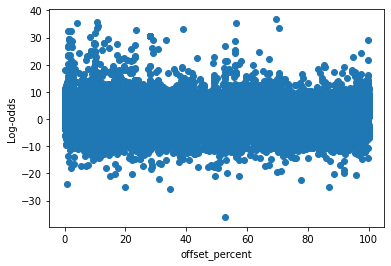

In [34]:
#Grabs probabilities and calculates log odds
pred = logreg.predict_proba(X_train)[:, 0]
log_odds = np.log(pred / (1 - pred))
#Plots log odds versus continuous variable to check for linearity
#Only one variable is tested as assumption is not met
plt.scatter(x = X_train['offset_percent'], y = log_odds)
plt.xlabel("offset_percent")
plt.ylabel("Log-odds")
plt.show()

### Random Forest Classifier
Finally, I tried a random forest classifier to see if an ensemble model would perform better than the logistic regression. I also tuned this model using a GridSearch and the resulting parameters are used below. While the training recall and accuracy of the random forest are better, it seems to overfit more and the recall for the validation set is much worse. As a result, I opted to stick with the untuned logistic regression as my best model.

In [36]:
#Pipeline for processing and fitting model
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['video_id', 'day_night'])],
    remainder = 'passthrough')

rfc_tune = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('rf', RandomForestClassifier(min_samples_split = 10, random_state = 213))
])

#Fits model and prints training score
rfc_tune.fit(X_train, y_train)
preds = rfc_tune.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", rfc_tune.score(X_train, y_train))
#Cross validates model and prints average result
scores = cross_validate(rfc_tune, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.995819397993311
Training Accuracy: 0.998286270691334
Validation Recall:0.4155823508358173
Validation Accuracy:0.9305679974034404


## Evaluation
---
The main metric used to evaluate this is recall as I wanted to weight the model against false negatives. Since chats are ultimately being flagged for manual review, mislabeling some neutral and positive chats as negative is a fair tradeoff for capturing as many negative chats as possible. The results for the test set are displayed below, with the final model reaching a recall of 76%. The confusion matrix for this model is also printed to get a sense of how well the model does overall.

In [16]:
#Test results for final model
preds = logreg.predict(X_test)
print("Test Recall:", recall_score(preds, y_test))
print("Test Accuracy:", logreg.score(X_test, y_test))

Test Recall: 0.7553497285212393
Test Accuracy: 0.9522492697176241


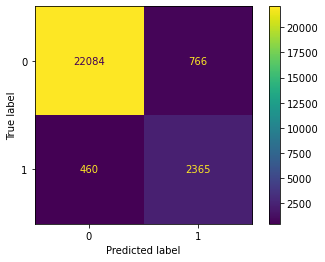

In [26]:
#Plts confusion matric for test data
cm = confusion_matrix(y_test, preds)
cmdis = ConfusionMatrixDisplay(cm)
cmdis.plot();

The final model overall does fairly well. Due to the recall score and labels coming from VADER, I would recommend implementing the model as a tool for moderators to use to help them sort through chats more efficiently. Therefore, the final model could help flag potential hate comments that would inform moderators faster of potentially problematic chats. Furthermore, the log odds of certain words predicting a negative chat can be drawn out from the model. These can be used to decide what words might be good to add to the chat filter to help improve it.

## Conclusion
---
Overall, this model has high potential as a tool to help streamers and moderators identify hate faster. This model can also help strengthen existing filters to make the system more effective. On its own though, the model is still lacking in fully tackling the hate speech problem present on Twitch. Going forward, it would therefore be useful to get more accurate labels for the data to help train a more useable model. It would also be useful to model other languages. Finally, training models for different streaming categories would also be useful, as word contexts change depending on what’s being streamed.

## References
---
#### Data:
Kim, J. (2019, August 1). Twitch.tv chat log data. Harvard Dataverse. Retrieved November 30, 2021, from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910%2FDVN%2FVE0IVQ. 

#### Sources:
Würzburg, K. K. J.-M.-U., Kobs, K., Würzburg, J.-M.-U., Würzburg, A. Z. J.-M.-U., Zehe, A., Würzburg, A. B. J.-M.-U., Bernstetter, A., Würzburg, J. C. J.-M.-U., Chibane, J., Würzburg, J. P. J.-M.-U., Pfister, J., Würzburg, J. T. J.-M.-U., Tritscher, J., Würzburg, A. H. J.-M.-U., Hotho, A., University, S., &amp; Metrics, O. M. V. A. (2020, May 1). Emote-controlled: Obtaining implicit viewer feedback through emote-based sentiment analysis on comments of popular Twitch.tv channels. ACM Transactions on Social Computing. Retrieved November 30, 2021, from https://dl.acm.org/doi/10.1145/3365523. 

Yosilewitz, A. (2018, August 6). Streamelements analysis on Twitch bullying. Medium. Retrieved November 30, 2021, from https://blog.streamelements.com/streamelements-analysis-on-twitch-bullying-c3f2b2240318. 